In [1]:
import os 
import glob
from pathlib import Path
from rtmag.paper.parse import parse_tai_string
from sunpy.map import Map
import numpy as np
from skimage.transform import resize
from rtmag.paper.load import load_input_label, MyModel

In [2]:
data_path = "/mnt/f/sdo_AR/NOAA11158_HARP377/hmi"
hmi_p_files = sorted(glob.glob(os.path.join(data_path, '*Bp.fits')))  # x
hmi_t_files = sorted(glob.glob(os.path.join(data_path, '*Bt.fits')))  # y
hmi_r_files = sorted(glob.glob(os.path.join(data_path, '*Br.fits')))  # z
data_paths = list(zip(hmi_p_files, hmi_t_files, hmi_r_files))

In [3]:
ix = 240
data_path = data_paths[ix]
data_path

('/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Bp.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Bt.fits',
 '/mnt/f/sdo_AR/NOAA11158_HARP377/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Br.fits')

In [4]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/11158")
len(input_files), len(label_files)

(66, 66)

In [5]:
idx = 13
input_files[idx], label_files[idx]

(PosixPath('/mnt/f/isee_dataset/11158/input/input_11158_20110214_000000.npz'),
 PosixPath('/mnt/f/isee_dataset/11158/label/label_11158_20110214_000000.npz'))

In [6]:
from time import time

In [7]:
mm = MyModel("/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt")

Model loaded from epoch 75


In [8]:
# tstr = Path(data_path[0]).name[23:38]
# obstime = parse_tai_string(tstr)
hmi_p, hmi_t, hmi_r, = data_path
p_map, t_map, r_map = Map(hmi_p), Map(hmi_t), Map(hmi_r)
maps = [p_map, t_map, r_map]
hmi_data = np.stack([maps[0].data, -maps[1].data, maps[2].data]).transpose()
hmi_data = np.nan_to_num(hmi_data, nan=0.0)
hmi_data = hmi_data.astype(np.float32)

# ox, oy, _ = hmi_data.shape
nx, ny = 512, 256

# l = 0.36 # Mm

# dx = (ox * l)/nx
# dy = (oy * l)/ny
# dz = dy 

# dx, dy, dz = dx * 1e8, dy * 1e8, dz * 1e8  # cm
# dV = dx * dy * dz # cm^3

model_input = resize(hmi_data, (nx, ny, 3))
model_input = model_input[None, :, :, None, :]
model_input = model_input.transpose(0, 3, 2, 1, 4)
model_input.shape

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


(1, 1, 256, 512, 3)

In [9]:
b = mm.get_pred_from_numpy(model_input)

Model loaded from epoch 75


In [11]:
B = mm.get_label(label_files[idx])

In [16]:
x, y, z = mm.get_coords(label_files[idx])

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

In [18]:
left_title = "Ground Truth"
right_title = "Prediction"
title_y = 1.10

title_fontsize = 25
bar_title_fontsize = 15
bar_ticks_fontsize = 10

label_fontsize = 12
tick_fontsize = 10

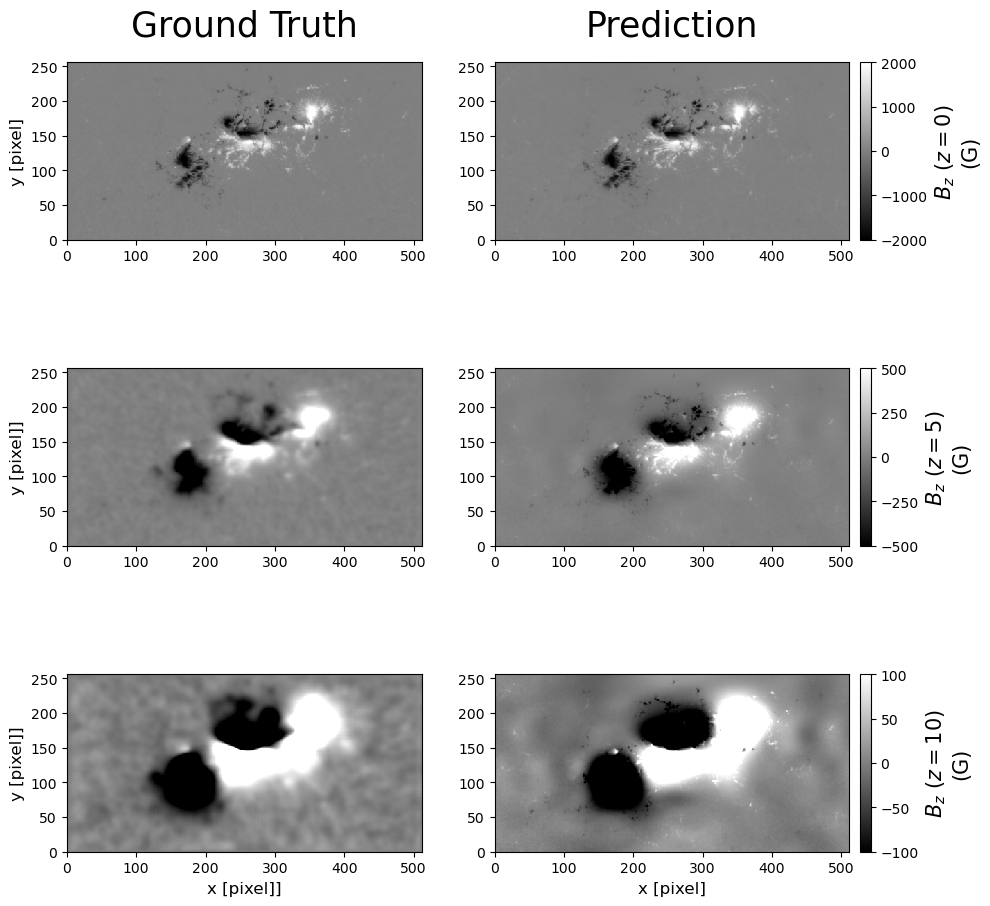

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

z = 0
vmm = 2000
axs[0, 0].pcolormesh(B[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
axs[0, 0].set_title(left_title, fontsize=title_fontsize, y=title_y)
# axs[0, 0].set_xticks([])
# axs[0, 0].set_yticks([])
# axs[0, 0].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)
axs[0, 0].set_ylabel("y [pixel]", fontsize=label_fontsize)
axs[0, 0].tick_params(labelsize=tick_fontsize)
axs[0, 0].set_aspect("equal")
# axs[0, 0].annotation(f"z={z}", xy=(0.10, 0.90), xycoords="axes fraction", fontsize=bar_title_fontsize, ha="center", va="center", color=truth_color, bbox=dict(botsize="square"))

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="3%", pad="3%")
cax.set_xticks([])
cax.set_yticks([])
cax.axis("off")

im = axs[0, 1].pcolormesh(b[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
axs[0, 1].set_title(right_title, fontsize=title_fontsize, y=title_y)
# axs[0, 1].set_xticks([])
# axs[0, 1].set_yticks([])
# axs[0, 1].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)
# axs[0, 1].set_ylabel("y (northward) [Mm]", fontsize=label_fontsize)
axs[0, 1].sharey(axs[0, 0])
axs[0, 1].tick_params(labelsize=tick_fontsize)
axs[0, 1].set_aspect("equal")
# axs[0, 1].annotate(f"z={z}", xy=(0.10, 0.90), xycoords="axes fraction", fontsize=bar_title_fontsize, ha="center", va="center", color=pred_color)
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="3%", pad="3%")
cb = fig.colorbar(im, cax=cax, ticks=[-vmm, -vmm/2, 0, vmm/2, vmm])
cb.set_label('$B_z$ $(z='+f'{z}'+')$\n(G)', size=bar_title_fontsize)
cax.tick_params(labelsize=bar_ticks_fontsize)



z = 5
vmm = 500
axs[1, 0].pcolormesh(B[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[1, 0].set_title("ISEE $B_z$ $(z=5)$")
# axs[1, 0].set_xticks([])
# axs[1, 0].set_yticks([])
# axs[1, 0].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)
axs[1, 0].sharex(axs[0, 0])
axs[1, 0].set_ylabel("y [pixel]]", fontsize=label_fontsize)
axs[1, 0].tick_params(labelsize=tick_fontsize)
axs[1, 0].set_aspect("equal")

divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="3%", pad="3%")
cax.set_xticks([])
cax.set_yticks([])
cax.axis("off")

im = axs[1, 1].pcolormesh(b[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[1, 1].set_title("PINO $B_z$ $(z=5)$")
# axs[1, 1].set_xticks([])
# axs[1, 1].set_yticks([])
# axs[1, 1].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)

# axs[1, 1].set_ylabel("y (northward) [Mm]", fontsize=label_fontsize)
axs[1, 1].sharex(axs[0, 1])
axs[1, 1].sharey(axs[1, 0])
axs[1, 1].tick_params(labelsize=tick_fontsize)
axs[1, 1].set_aspect("equal")
# axs[1, 1].text(label_pos[0],label_pos[1], f"z ={z:2d}", fontsize=text_fontsize, ha="center", va="center", color=pred_color, bbox=dict(facecolor='white', alpha=1.0))

# cax = fig.add_axes([1.01, 0.38, 0.025, 0.24])
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="3%", pad="3%")
cb = fig.colorbar(im, cax=cax, ticks=[-vmm, -vmm/2, 0, vmm/2, vmm])
cb.set_label('$B_z$ $(z='+f'{z}'+')$\n(G)', size=bar_title_fontsize)
# fig.colorbar(im)




z = 10
vmm = 100
axs[2, 0].pcolormesh(B[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[2, 0].set_title("ISEE $B_z$ $(z=10)$")
# axs[2, 0].set_xticks([])
# axs[2, 0].set_yticks([])
axs[2, 0].set_xlabel("x [pixel]]", fontsize=label_fontsize)
axs[2, 0].sharex(axs[0, 0])
axs[2, 0].set_ylabel("y [pixel]]", fontsize=label_fontsize)
axs[2, 0].tick_params(labelsize=tick_fontsize)
axs[2, 0].set_aspect("equal")
# axs[2, 0].text(label_pos[0],label_pos[1], f"z ={z:2d}", fontsize=text_fontsize, ha="center", va="center", color=truth_color, bbox=dict(facecolor='white', alpha=1.0))

divider = make_axes_locatable(axs[2, 0])
cax = divider.append_axes("right", size="3%", pad="3%")
cax.set_xticks([])
cax.set_yticks([])
cax.axis("off")

im = axs[2, 1].pcolormesh(b[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[2, 1].set_title("PINO $B_z$ $(z=10)$")
# axs[2, 1].set_xticks([])
# axs[2, 1].set_yticks([])
axs[2, 1].set_xlabel("x [pixel]", fontsize=label_fontsize)
# axs[2, 1].set_ylabel("y (northward) [Mm]", fontsize=label_fontsize)
axs[2, 1].sharex(axs[0, 1])
axs[2, 1].sharey(axs[2, 0])
axs[2, 1].tick_params(labelsize=tick_fontsize)
axs[2, 1].set_aspect("equal")
# axs[2, 1].text(label_pos[0],label_pos[1], f"z ={z:2d}", fontsize=text_fontsize, ha="center", va="center", color=pred_color, bbox=dict(facecolor='white', alpha=1.0))

# cax = fig.add_axes([1.01, 0.07, 0.025, 0.238])
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes("right", size="3%", pad="3%")
cb = fig.colorbar(im, cax=cax, ticks=[-vmm, -vmm/2, 0, vmm/2, vmm])
cb.set_label('$B_z$ $(z='+f'{z}'+')$\n(G)', size=bar_title_fontsize)
# fig.colorbar(im)


plt.tight_layout()
plt.show()

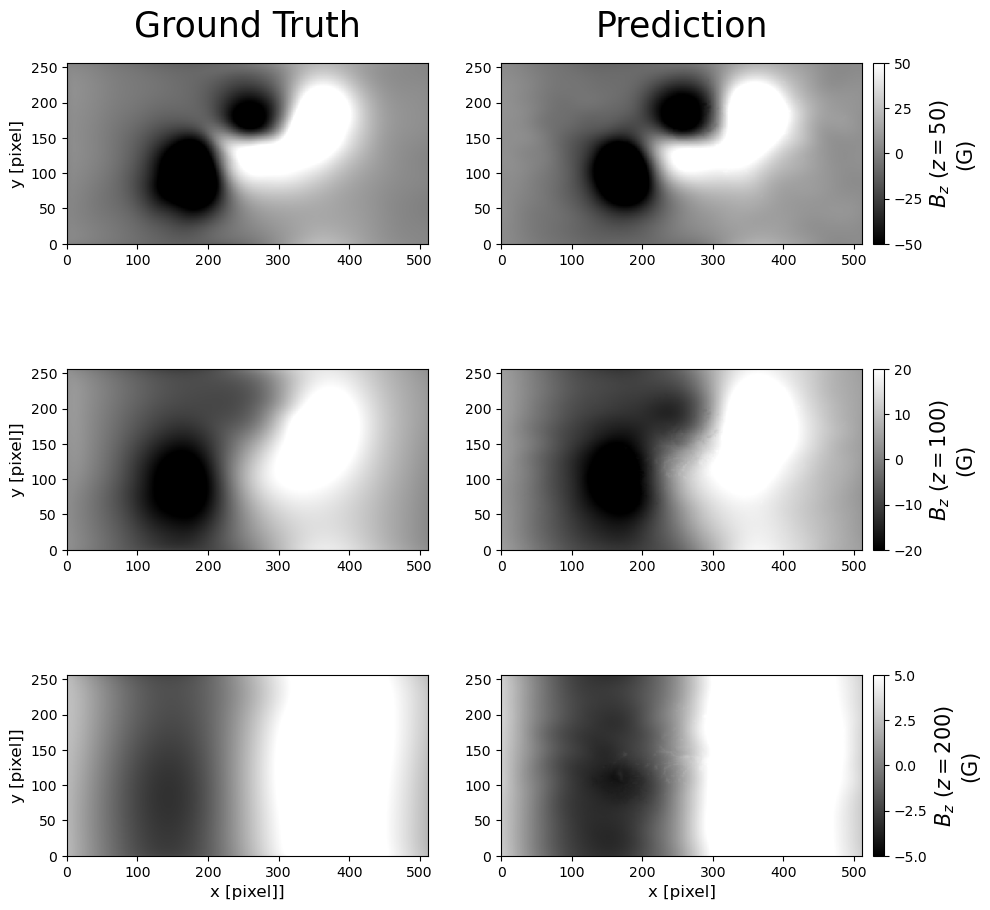

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

z = 50
vmm = 50
axs[0, 0].pcolormesh(B[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
axs[0, 0].set_title(left_title, fontsize=title_fontsize, y=title_y)
# axs[0, 0].set_xticks([])
# axs[0, 0].set_yticks([])
# axs[0, 0].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)
axs[0, 0].set_ylabel("y [pixel]", fontsize=label_fontsize)
axs[0, 0].tick_params(labelsize=tick_fontsize)
axs[0, 0].set_aspect("equal")
# axs[0, 0].annotation(f"z={z}", xy=(0.10, 0.90), xycoords="axes fraction", fontsize=bar_title_fontsize, ha="center", va="center", color=truth_color, bbox=dict(botsize="square"))

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes("right", size="3%", pad="3%")
cax.set_xticks([])
cax.set_yticks([])
cax.axis("off")

im = axs[0, 1].pcolormesh(b[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
axs[0, 1].set_title(right_title, fontsize=title_fontsize, y=title_y)
# axs[0, 1].set_xticks([])
# axs[0, 1].set_yticks([])
# axs[0, 1].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)
# axs[0, 1].set_ylabel("y (northward) [Mm]", fontsize=label_fontsize)
axs[0, 1].sharey(axs[0, 0])
axs[0, 1].tick_params(labelsize=tick_fontsize)
axs[0, 1].set_aspect("equal")
# axs[0, 1].annotate(f"z={z}", xy=(0.10, 0.90), xycoords="axes fraction", fontsize=bar_title_fontsize, ha="center", va="center", color=pred_color)
divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes("right", size="3%", pad="3%")
cb = fig.colorbar(im, cax=cax, ticks=[-vmm, -vmm/2, 0, vmm/2, vmm])
cb.set_label('$B_z$ $(z='+f'{z}'+')$\n(G)', size=bar_title_fontsize)
cax.tick_params(labelsize=bar_ticks_fontsize)



z = 100
vmm = 20
axs[1, 0].pcolormesh(B[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[1, 0].set_title("ISEE $B_z$ $(z=5)$")
# axs[1, 0].set_xticks([])
# axs[1, 0].set_yticks([])
# axs[1, 0].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)
axs[1, 0].sharex(axs[0, 0])
axs[1, 0].set_ylabel("y [pixel]]", fontsize=label_fontsize)
axs[1, 0].tick_params(labelsize=tick_fontsize)
axs[1, 0].set_aspect("equal")

divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes("right", size="3%", pad="3%")
cax.set_xticks([])
cax.set_yticks([])
cax.axis("off")

im = axs[1, 1].pcolormesh(b[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[1, 1].set_title("PINO $B_z$ $(z=5)$")
# axs[1, 1].set_xticks([])
# axs[1, 1].set_yticks([])
# axs[1, 1].set_xlabel("x (westward) [Mm]", fontsize=label_fontsize)

# axs[1, 1].set_ylabel("y (northward) [Mm]", fontsize=label_fontsize)
axs[1, 1].sharex(axs[0, 1])
axs[1, 1].sharey(axs[1, 0])
axs[1, 1].tick_params(labelsize=tick_fontsize)
axs[1, 1].set_aspect("equal")
# axs[1, 1].text(label_pos[0],label_pos[1], f"z ={z:2d}", fontsize=text_fontsize, ha="center", va="center", color=pred_color, bbox=dict(facecolor='white', alpha=1.0))

# cax = fig.add_axes([1.01, 0.38, 0.025, 0.24])
divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes("right", size="3%", pad="3%")
cb = fig.colorbar(im, cax=cax, ticks=[-vmm, -vmm/2, 0, vmm/2, vmm])
cb.set_label('$B_z$ $(z='+f'{z}'+')$\n(G)', size=bar_title_fontsize)
# fig.colorbar(im)




z = 200
vmm = 5
axs[2, 0].pcolormesh(B[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[2, 0].set_title("ISEE $B_z$ $(z=10)$")
# axs[2, 0].set_xticks([])
# axs[2, 0].set_yticks([])
axs[2, 0].set_xlabel("x [pixel]]", fontsize=label_fontsize)
axs[2, 0].sharex(axs[0, 0])
axs[2, 0].set_ylabel("y [pixel]]", fontsize=label_fontsize)
axs[2, 0].tick_params(labelsize=tick_fontsize)
axs[2, 0].set_aspect("equal")
# axs[2, 0].text(label_pos[0],label_pos[1], f"z ={z:2d}", fontsize=text_fontsize, ha="center", va="center", color=truth_color, bbox=dict(facecolor='white', alpha=1.0))

divider = make_axes_locatable(axs[2, 0])
cax = divider.append_axes("right", size="3%", pad="3%")
cax.set_xticks([])
cax.set_yticks([])
cax.axis("off")

im = axs[2, 1].pcolormesh(b[:, :, z, 2].T, cmap="gray", vmin=-vmm, vmax=vmm)
# axs[2, 1].set_title("PINO $B_z$ $(z=10)$")
# axs[2, 1].set_xticks([])
# axs[2, 1].set_yticks([])
axs[2, 1].set_xlabel("x [pixel]", fontsize=label_fontsize)
# axs[2, 1].set_ylabel("y (northward) [Mm]", fontsize=label_fontsize)
axs[2, 1].sharex(axs[0, 1])
axs[2, 1].sharey(axs[2, 0])
axs[2, 1].tick_params(labelsize=tick_fontsize)
axs[2, 1].set_aspect("equal")
# axs[2, 1].text(label_pos[0],label_pos[1], f"z ={z:2d}", fontsize=text_fontsize, ha="center", va="center", color=pred_color, bbox=dict(facecolor='white', alpha=1.0))

# cax = fig.add_axes([1.01, 0.07, 0.025, 0.238])
divider = make_axes_locatable(axs[2, 1])
cax = divider.append_axes("right", size="3%", pad="3%")
cb = fig.colorbar(im, cax=cax, ticks=[-vmm, -vmm/2, 0, vmm/2, vmm])
cb.set_label('$B_z$ $(z='+f'{z}'+')$\n(G)', size=bar_title_fontsize)
# fig.colorbar(im)


plt.tight_layout()
plt.show()